# Import libraries

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
#from skimage import io, transform
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Define auxiliar functions

In [2]:
# a simple custom collate function, just to show the idea
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]


def show_image_batch(img_list, title=None):
    num = len(img_list)
    fig = plt.figure()
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        ax.imshow(img_list[i].numpy().transpose([1,2,0]))
        ax.set_title(title[i])

    plt.show()

# Load Images

In [3]:
# batch size
bs = 32
# size of one side of the image
size = 128

In [4]:
# Load Data
dataset = datasets.ImageFolder(root='/home/martin/Dropbox/doctorado/chapter00_courses/procesamiento_digital_imagenes/final_project/pytorch/data/brain_tumor/brain_images/training_set', transform=transforms.Compose([
    transforms.Resize(size=(size,size)),
    transforms.Scale(size),
    transforms.RandomCrop(size),
    transforms.Grayscale(1),
    transforms.ToTensor()
]))   

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset = train_dataset, batch_size=bs, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset = test_dataset, batch_size=bs, shuffle=False, num_workers=0)

/home/martin/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


# Generate Noise samples

In [5]:
# the noise added to corrupt the images
noise_level = 0.2

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
im, labels = dataiter.next()
imag = im[0]

# Random Noise 
noise_random = torch.rand(bs,1,size,size)
img_noise_random = (imag.double()  + (noise_level * noise_random).double())

# Low Pass Filter
blur = cv2.GaussianBlur(imag.numpy(),(7,7),0,0.2)
img_noise_lpf = (torch.from_numpy(blur))

# LPF + random noise                           
img_noise_lpf_rn = (img_noise_lpf.double() + (noise_level * noise_random).double())

# size of the data

In [7]:
print("Len of the training set " + str(len(train_loader.dataset)))
print("Size of a raw image "+ str(imag.shape))
print("Size of a random noise picture " + str(img_noise_random[0].shape))
print("Size of a LPF picture " + str(img_noise_lpf.shape))
print("Size of a LPF+Noise picture " + str(img_noise_lpf_rn[0].shape))

Len of the training set 180
Size of a raw image torch.Size([1, 128, 128])
Size of a random noise picture torch.Size([1, 128, 128])
Size of a LPF picture torch.Size([1, 128, 128])
Size of a LPF+Noise picture torch.Size([1, 128, 128])


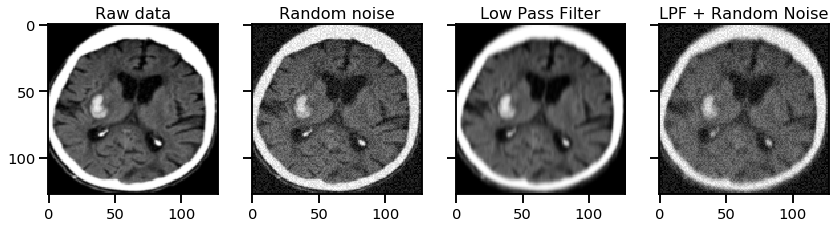

In [8]:
# visualize all types of images (raw and corrupted ones)

%matplotlib inline
sns.set_context("talk", font_scale=0.9)
f, axarr = plt.subplots(1,4,sharex=True, sharey=True)
f.set_size_inches(14, 12)
axarr[0].imshow(np.squeeze(imag), cmap='gray')
axarr[0].set_title('Raw data')
axarr[1].imshow(np.squeeze(img_noise_random[0]), cmap='gray')
axarr[1].set_title('Random noise')
axarr[2].imshow( np.squeeze(img_noise_lpf), cmap='gray')
axarr[2].set_title('Low Pass Filter')
axarr[3].imshow( np.squeeze(img_noise_lpf_rn[0]), cmap='gray')
axarr[3].set_title('LPF + Random Noise')
plt.show()

# Define Variational Autoencoder Model

In [9]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(int(size/4) * int(size/4) * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, int(size/4) * int(size/4) * 16)
        self.fc_bn4 = nn.BatchNorm1d(int(size/4) * int(size/4) * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, int(size/4) * int(size/4) * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, int(size/4), int(size/4))

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 1, size, size)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [10]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

# VAE Hyperparameters

In [11]:
batch_size = bs
epochs = 50
no_cuda = False
seed = 1
log_interval = 50
learning_rate = 7e-4
#learning_rate = 1e-3

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_mse = customLoss()
val_losses = []
train_losses = []

# Define train and test strategies

In [41]:
def train(epoch, noise_type):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
                                          
        if (noise_type == 'raw'):
            data_batch = data

        elif (noise_type == 'random'):
            noise_random = torch.rand(data.shape[0],1,size,size)
            data_batch = Variable(data  + (noise_level * noise_random))

        elif (noise_type == 'lpf'):
            
            # Low Pass Filter
            tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
            for t in range(data.shape[0]):
                tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
            blur = torch.from_numpy(tensor)
            data_batch = Variable(blur)
            
        elif (noise_type == 'lpf_random'):
            
            # Low Pass Filter
            tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
            for t in range(data.shape[0]):
                tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
            blur = torch.from_numpy(tensor)
            noise_random = torch.rand(data.shape[0],1,size,size)
            data_batch = Variable(blur.double() + (noise_level * noise_random))
        
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_batch)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item() / len(data)))
    train_losses.append(train_loss / len(train_loader.dataset))

In [50]:
def test(epoch, noise_type):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            
            if (noise_type == 'raw'):
                data_batch = data

            elif (noise_type == 'random'):
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(data  + (noise_level * noise_random))

            elif (noise_type == 'lpf'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(data.shape[0]):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                data_batch = Variable(blur)

            elif (noise_type == 'lpf_random'):

                # Low Pass Filter
                tensor = torch.Tensor(data.shape[0], 1, size, size).numpy()
                for t in range(bs):
                    tensor[t,:,:,:]= cv2.GaussianBlur(data[t].numpy(),(7,7),0,0.2)
                blur = torch.from_numpy(tensor)
                noise_random = torch.rand(data.shape[0],1,size,size)
                data_batch = Variable(blur.double() + (noise_level * noise_random))

            
            recon_batch, mu, logvar = model(data_batch)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

# Train with raw data

In [14]:
noise = 'raw'

for epoch in range(1, epochs + 1):
    train(epoch,noise)
    test(epoch, noise)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()

Train Epoch: 1 	Loss: 26223.937500
====> Test set loss: 4050.0734
Train Epoch: 2 	Loss: 10066.330078
====> Test set loss: 3882.5223
Train Epoch: 3 	Loss: 5037.623047
====> Test set loss: 3583.2988
Train Epoch: 4 	Loss: 2824.394531
====> Test set loss: 3136.3098
Train Epoch: 5 	Loss: 1923.209473
====> Test set loss: 2479.9518
Train Epoch: 6 	Loss: 1786.807861
====> Test set loss: 1766.2191
Train Epoch: 7 	Loss: 1588.588623
====> Test set loss: 1499.6583
Train Epoch: 8 	Loss: 1480.249512
====> Test set loss: 1229.7951
Train Epoch: 9 	Loss: 1307.279419
====> Test set loss: 1156.5992
Train Epoch: 10 	Loss: 1290.007446
====> Test set loss: 1095.4323
Train Epoch: 11 	Loss: 1246.718628
====> Test set loss: 1028.9087
Train Epoch: 12 	Loss: 1157.741333
====> Test set loss: 1007.5768
Train Epoch: 13 	Loss: 1146.884155
====> Test set loss: 993.7244
Train Epoch: 14 	Loss: 1058.389404
====> Test set loss: 979.9985
Train Epoch: 15 	Loss: 1045.661133
====> Test set loss: 887.9397
Train Epoch: 16 	Los

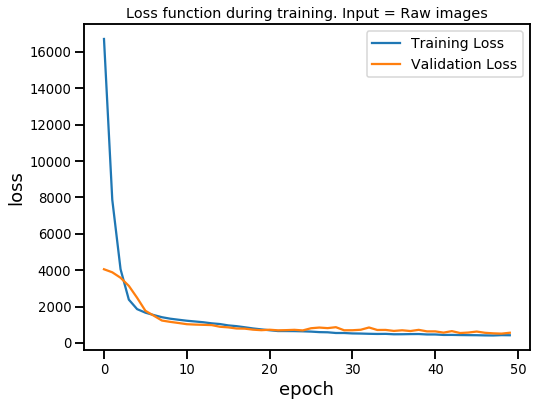

In [15]:
sns.set_context("talk", font_scale=0.8)
plt.figure(figsize=(8,6))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Loss function during training. Input = Raw images")
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

# Evaluate model with independent test samples

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

# get sample outputs
output_raw = model(images_raw)
# prep images for display
images_raw = images_raw.detach().numpy()

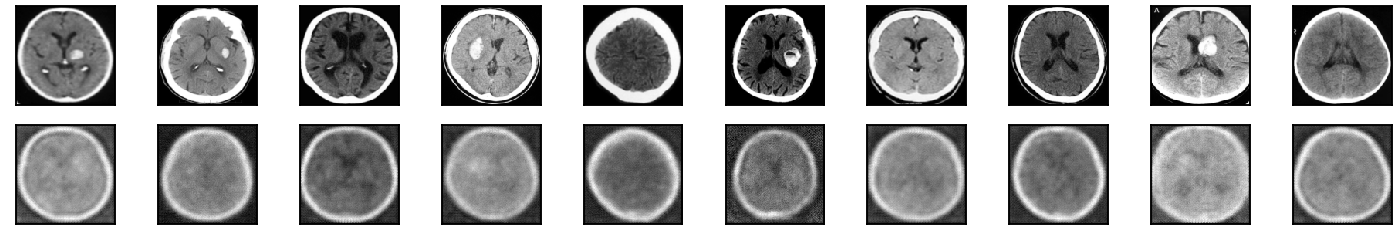

In [17]:
output_raw_im = output_raw[0]
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images_raw, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Train with Low Pass Filter

In [42]:
batch_size = bs
epochs = 50
no_cuda = False
seed = 1
log_interval = 50
learning_rate = 7e-4
#learning_rate = 1e-3

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_mse = customLoss()
val_losses = []
train_losses = []

In [43]:
noise = 'lpf'

for epoch in range(1, epochs + 1):
    train(epoch,noise)
    test(epoch, noise)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()

Train Epoch: 1 	Loss: 26216.294922
====> Test set loss: 4050.8754
Train Epoch: 2 	Loss: 10071.330078
====> Test set loss: 3888.0016
Train Epoch: 3 	Loss: 4957.901367
====> Test set loss: 3593.4543
Train Epoch: 4 	Loss: 2865.141602
====> Test set loss: 3156.6049
Train Epoch: 5 	Loss: 1975.776367
====> Test set loss: 2579.2223
Train Epoch: 6 	Loss: 1795.069336
====> Test set loss: 2040.6031
Train Epoch: 7 	Loss: 1621.862427
====> Test set loss: 1477.9728
Train Epoch: 8 	Loss: 1481.322266
====> Test set loss: 1236.7913
Train Epoch: 9 	Loss: 1281.560303
====> Test set loss: 1170.1848
Train Epoch: 10 	Loss: 1276.408813
====> Test set loss: 1057.8285
Train Epoch: 11 	Loss: 1181.381348
====> Test set loss: 1103.0596
Train Epoch: 12 	Loss: 1109.839111
====> Test set loss: 930.2628
Train Epoch: 13 	Loss: 1057.071777
====> Test set loss: 925.8853
Train Epoch: 14 	Loss: 952.678467
====> Test set loss: 886.2109
Train Epoch: 15 	Loss: 921.656616
====> Test set loss: 817.2223
Train Epoch: 16 	Loss: 

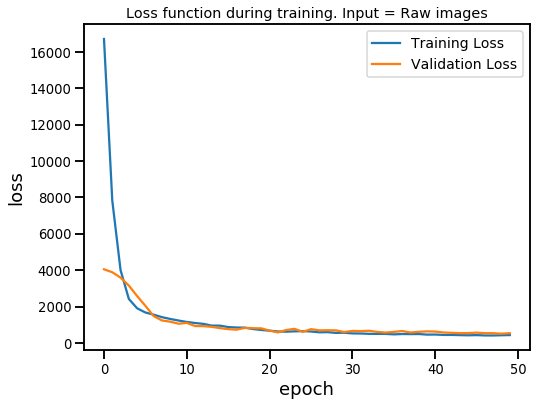

In [44]:
sns.set_context("talk", font_scale=0.8)
plt.figure(figsize=(8,6))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Loss function during training. Input = Raw images")
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

In [45]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

# get sample outputs
output_raw = model(images_raw)
# prep images for display
images_raw = images_raw.detach().numpy()

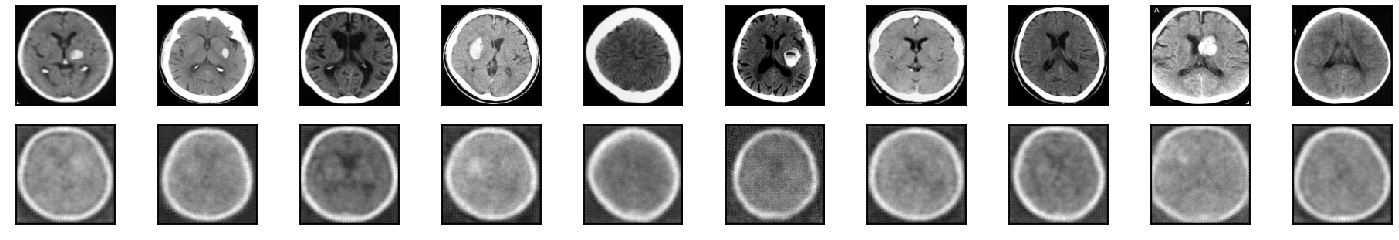

In [46]:
output_raw_im = output_raw[0]
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images_raw, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Train with random noise

In [51]:
batch_size = bs
epochs = 50
no_cuda = False
seed = 1
log_interval = 50
learning_rate = 7e-4

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_mse = customLoss()
val_losses = []
train_losses = []

In [53]:
noise = 'random'

for epoch in range(1, epochs + 1):
    train(epoch,noise)
    test(epoch, noise)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()

Train Epoch: 1 	Loss: 26126.330078
====> Test set loss: 4045.3496
Train Epoch: 2 	Loss: 10154.481445
====> Test set loss: 3866.4191
Train Epoch: 3 	Loss: 5180.935059
====> Test set loss: 3580.2191
Train Epoch: 4 	Loss: 2844.137451
====> Test set loss: 3160.5338
Train Epoch: 5 	Loss: 1926.477051
====> Test set loss: 2448.0801
Train Epoch: 6 	Loss: 1765.226562
====> Test set loss: 1847.6850
Train Epoch: 7 	Loss: 1603.504028
====> Test set loss: 1448.2680
Train Epoch: 8 	Loss: 1441.339233
====> Test set loss: 1263.0463
Train Epoch: 9 	Loss: 1410.343140
====> Test set loss: 1203.7527
Train Epoch: 10 	Loss: 1308.302002
====> Test set loss: 1170.6858
Train Epoch: 11 	Loss: 1242.808228
====> Test set loss: 1116.3443
Train Epoch: 12 	Loss: 1210.389160
====> Test set loss: 1020.0440
Train Epoch: 13 	Loss: 1173.636230
====> Test set loss: 1059.6820
Train Epoch: 14 	Loss: 1133.403442
====> Test set loss: 941.6520
Train Epoch: 15 	Loss: 1073.607666
====> Test set loss: 956.3627
Train Epoch: 16 	Lo

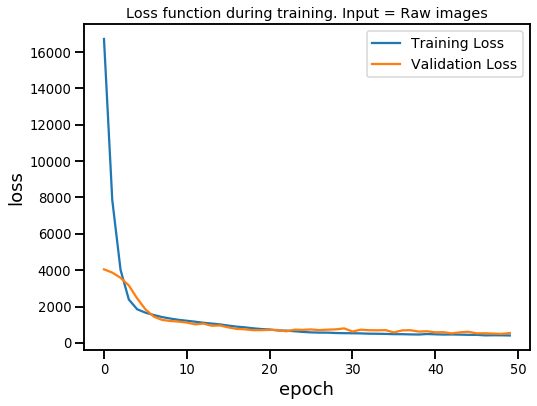

In [54]:
sns.set_context("talk", font_scale=0.8)
plt.figure(figsize=(8,6))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Loss function during training. Input = Raw images")
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

In [64]:
# obtain one batch of test images
dataiter = iter(test_loader)
images_raw, labels = dataiter.next()

noise_random_te = torch.rand(images_raw.shape[0],1,size,size)
data_batch_te = Variable(images_raw  + (0.6 * noise_random_te))

# get sample outputs
output_raw = model(data_batch_te)
# prep images for display
images_raw = images_raw.detach().numpy()

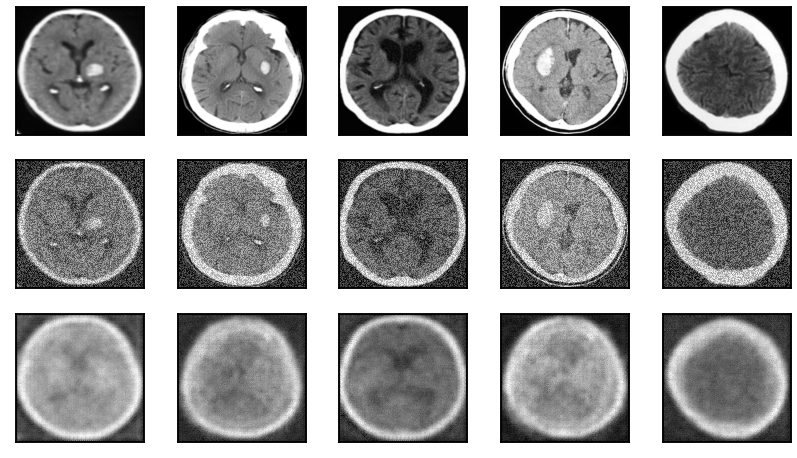

In [65]:
output_raw_im = output_raw[0]
output_raw_im = output_raw_im.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(14,8))

# input images on top row, reconstructions on bottom
for images, row in zip([images_raw,data_batch_te, output_raw_im], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)